<a href="https://colab.research.google.com/github/Shuvro-Ahmed/Daily-Sales-Forcasting/blob/main/Total_Sales_Forcasting_in_a_Supershop_(Daily).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error #evaluation matric, For regression problem's accuracy, just like conf. matrice in classification task
from tensorflow.keras.models import Sequential #Sequential model is a linear stack of layers. 
from tensorflow.keras.layers import Dense, LSTM, Flatten #Layers are the basic building blocks of neural networks in Keras.
# The dense layer in neural networks is the one that executes matrix-vector multiplication. And, LSTM is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #Callbacks are useful to get a view on internal states and statistics of the model during training.
#EarlyStopping is a callback used while training neural networks, which provides us the advantage of using a large number of training epochs and stopping the training once the model's performance stops improving on the validation Dataset.
#ModelCheckpoint callback is used in conjunction with training using model. fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
store_sales = pd.read_csv('/content/drive/MyDrive/Thesis data/Report (1).csv')
store_sales.head(10)

,INVOICE,S_CODE,CLASS_NAME,CODE,NAME,QTY,RATE,TOTAL,COST_PRICE
0,OC3801-01-2201000001,1/1/2022,Sweet & Fast Food,2500000114,Tasty Treat Butter Bun 100gm,1.0,30.0,30.0,21.60
1,OC3801-01-2201000001,1/1/2022,Beverage,3000000463,Coca-Cola 250ml Zero PET,1.0,20.0,20.0,13.86
2,OC3801-01-2201000001,1/1/2022,Beverage,3000000435,Royal Crown Club Soda 500ml,1.0,30.0,30.0,25.00
3,OC3801-01-2201000001,1/1/2022,Personal Care,6000001263,Himalaya Aloe Vera Face Wash 100ml,1.0,190.0,190.0,142.50
4,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000565,All Time Milk Bread 300gm,1.0,45.0,45.0,34.20
5,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000349,PRAN Jhatpat Paratha Low Fat 10pcs 600gm,1.0,100.0,100.0,72.00
6,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000402,All Time Sandwich Bread 300gm,1.0,40.0,40.0,29.90
7,OC3801-01-2201000002,1/1/2022,Commodities,3500000120,BSFIC Brown Sugar 1kg,1.0,85.0,85.0,66.57
8,OC3801-01-2201000003,1/1/2022,Packaged Food,5500000078,PRAN Mr. Noodle 12ps Magic Masala,1.0,210.0,210.0,157.22
9,OC3801-01-2201000003,1/1/2022,Packaged Food,5500001605,Pringles Original 42gm (Malaysia),1.0,100.0,100.0,80.00


In [ ]:
type(store_sales['QTY'][0])

numpy.float64

In [ ]:
store_sales['QTY'] = store_sales['QTY'].astype('int')
type(store_sales['QTY'][0])

numpy.int64

NULL CHECK

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   INVOICE     158293 non-null  object 
 1   S_CODE      158293 non-null  object 
 2   CLASS_NAME  158293 non-null  object 
 3   CODE        158293 non-null  int64  
 4   NAME        158293 non-null  object 
 5   QTY         158293 non-null  int64  
 6   RATE        158293 non-null  float64
 7   TOTAL       158293 non-null  float64
 8   COST_PRICE  158293 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 10.9+ MB


Drop Irrelevant Column

In [ ]:
store_sales = store_sales.drop(['INVOICE','CLASS_NAME','CODE','NAME','RATE','TOTAL','COST_PRICE'], axis=1)


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   S_CODE  158293 non-null  object
 1   QTY     158293 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Rename column

In [ ]:
store_sales.rename(columns = {'S_CODE':'Date'}, inplace = True)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    158293 non-null  object
 1   QTY     158293 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Convert to datetime datatype -> "Date"

In [ ]:
store_sales['Date'] = pd.to_datetime(store_sales['Date'])

In [ ]:
store_sales.head()

,Date,QTY
0,2022-01-01,1
1,2022-01-01,1
2,2022-01-01,1
3,2022-01-01,1
4,2022-01-01,1


Daily Sales

In [ ]:
store_sales['Date'] = store_sales['Date'].dt.to_period('D')
daily_sales = store_sales.groupby('Date')['QTY'].sum().reset_index()
#daily_sales['Date'] = daily_sales['Date'].dt.to_timestamp()
daily_sales = daily_sales.set_index("Date")

In [ ]:
daily_sales

,QTY
Date,
2022-01-01,710
2022-01-02,782
2022-01-03,956
2022-01-04,2530
2022-01-05,1590
...,...
2022-12-06,811
2022-12-07,1059
2022-12-08,2162


Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the rolling method to begin a windowed computation. Follow this by the mean method to compute the average over the window.
As we can see, the trend of Tunnel Traffic appears to be about linear.

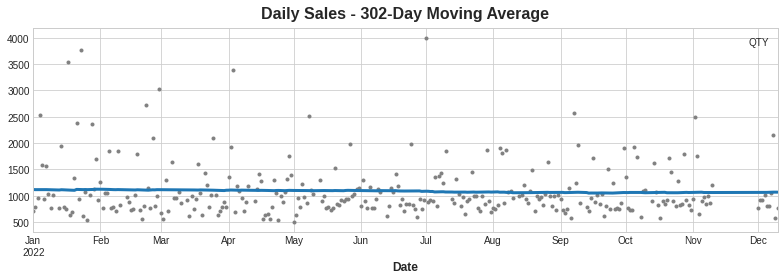

In [ ]:
moving_average = daily_sales.rolling(
    window=302,       # 302-day window
    center=True,      # puts the average at the center of the window
    min_periods=151,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = daily_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Daily Sales - 302-Day Moving Average", legend=False,
);

In Lesson 1, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the statsmodels library called DeterministicProcess. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=daily_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2022-01-01,1.0,1.0
2022-01-02,1.0,2.0
2022-01-03,1.0,3.0
2022-01-04,1.0,4.0
2022-01-05,1.0,5.0


(A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the fit_intercept=False argument.

In [ ]:
from sklearn.linear_model import LinearRegression

y = daily_sales["QTY"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

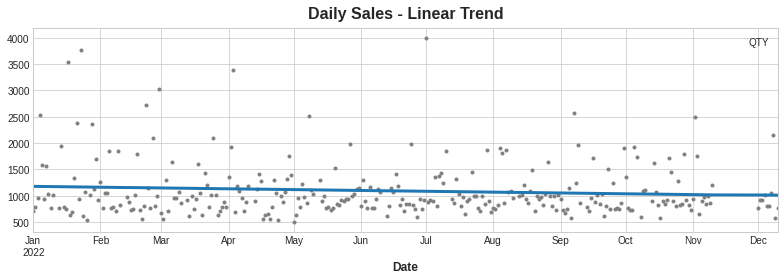

In [ ]:
ax = daily_sales.plot(style=".", color="0.5", title="Daily Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [ ]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-12-11    1009.521551
2022-12-12    1008.964090
2022-12-13    1008.406630
2022-12-14    1007.849169
2022-12-15    1007.291709
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

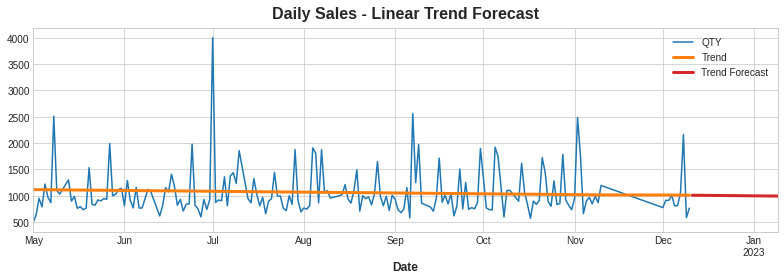

In [ ]:
ax = daily_sales["2022-05":].plot(title="Daily Sales - Linear Trend Forecast")
ax = y_pred["2022-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()


The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique in Lesson 5.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

Seasonal Plots and Seasonal Indicators
Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.


There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.
Seasonal indicators
Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the Trigonometry series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators, choosed monday in the example)

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:


Ordinary linear regression learns the mean values at each time in the season.
The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of 1 (On). In kaggle example, Linear regression learns a baseline value 2379 for Mon and then adjusts by the value of whichever indicator is On for that day; the rest are 0 and vanish

Fourier Features and the Periodogram
The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in Trigonometry. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the Wiki Trigonometry series.

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting

**Choosing Fourier features with the Periodogram**
# How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

From left to right, the periodogram drops off after Quarterly, four times a year. That was why we chose four Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

**Computing Fourier features (optional)**

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from statsmodels for our applications, however.)

In [ ]:
'''
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
# fourier_features(y, freq=365.25, order=4)
'''

'\nimport numpy as np\n\n\ndef fourier_features(index, freq, order):\n    time = np.arange(len(index), dtype=np.float32)\n    k = 2 * np.pi * (1 / freq) * time\n    features = {}\n    for i in range(1, order + 1):\n        features.update({\n            f"sin_{freq}_{i}": np.sin(i * k),\n            f"cos_{freq}_{i}": np.cos(i * k),\n        })\n    return pd.DataFrame(features, index=index)\n\n\n# Compute Fourier features to the 4th order (8 new features) for a\n# series y with daily observations and annual seasonality:\n# fourier_features(y, freq=365.25, order=4)\n'

defines two functions: seasonal_plot and plot_periodogram

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier
import seaborn as sns
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Let's take a look at seasonal plots over a week and over a year.

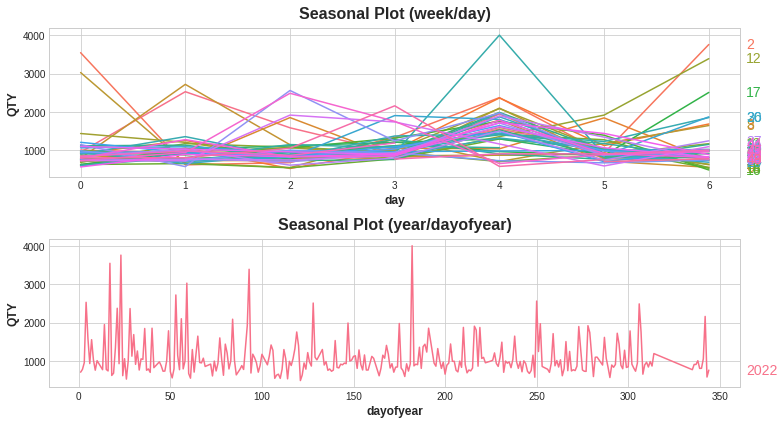

In [ ]:
X = daily_sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="QTY", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="QTY", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

<ipython-input-83-e89f7a3b1e54>:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(daily_sales.QTY);


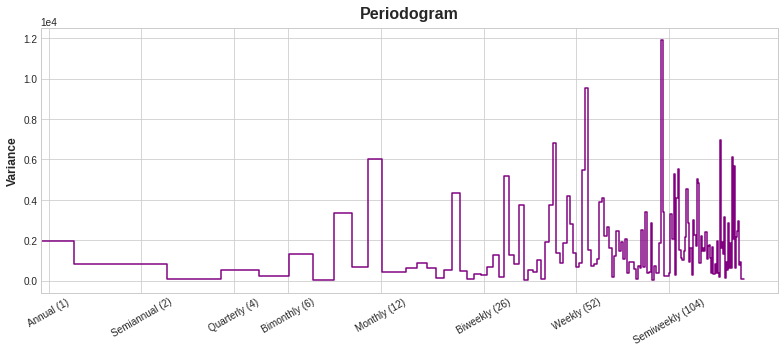

In [ ]:
plot_periodogram(daily_sales.QTY);

The periodogram agrees with the seasonal plots above: a strong weekly season, semiweekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Monthly (12) and Biweekly(26)?, so let's use 13 Fourier pairs as this gives us a good curve lmao.

We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [ ]:
fourier = CalendarFourier(freq="A", order=13)  # 13 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=daily_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in daily_sales.index

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

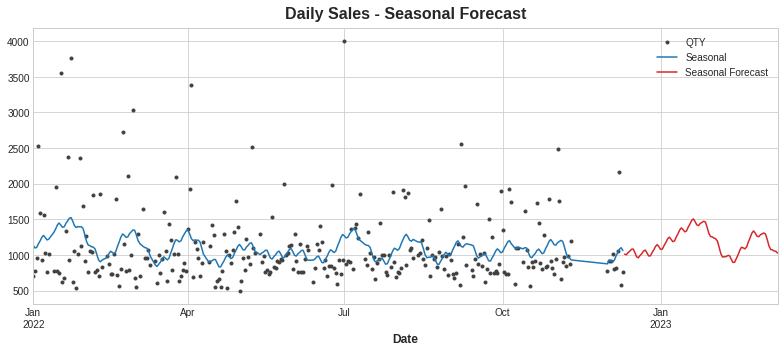

In [ ]:
y = daily_sales["QTY"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Daily Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()


**Time Series as Features**

Predict the future from the past with a lag embedding.

What is Serial Dependence?

In earlier lessons, we investigated properties of time series that were most easily modeled as time dependent properties, that is, with features we could derive directly from the time index. Some time series properties, however, can only be modeled as serially dependent properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear -- as we see in the figure below below.

With trend and seasonality, we trained models to fit curves to plots like those on the left in the figure above -- the models were learning time dependence. The goal in this lesson is to train models to fit curves to plots like those on the right -- we want them to learn serial dependence.

**Cycles**

One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

**Lagged Series and Lag Plots**

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (y) together with its first and second lagged series (y_lag_1 and y_lag_2, respectively). Notice how the values of the lagged series are shifted forward in time.

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use y_lag_1 and y_lag_2 as features to predict the target y. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

Lag plots

A lag plot of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. We can see from this lag plot of US Unemployment that there is a strong and apparently linear relationship between the current unemployment rate and past rates.The most commonly used measure of serial dependence is known as autocorrelation, which is simply the correlation a time series has with one of its lags. US Unemployment has an autocorrelation of 0.99 at lag 1, 0.98 at lag 2, and so on.


**Choosing lags**

When choosing lags to use as features, it generally won't be useful to include every lag with a large autocorrelation. In US Unemployment, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.


The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for US Unemployment. (Lag 11 is likely a false positive.)


A plot like that above is known as a correlogram. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of linear dependence. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like mutual information) when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation.

Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.


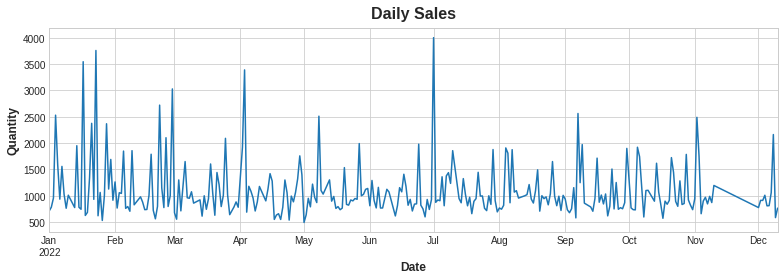

In [ ]:
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

ax = daily_sales.QTY.plot(title='Daily Sales')
_ = ax.set(ylabel="Quantity")

We see more cycle irregularity here, then as a regular seasonality. so, better to use lags.

Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

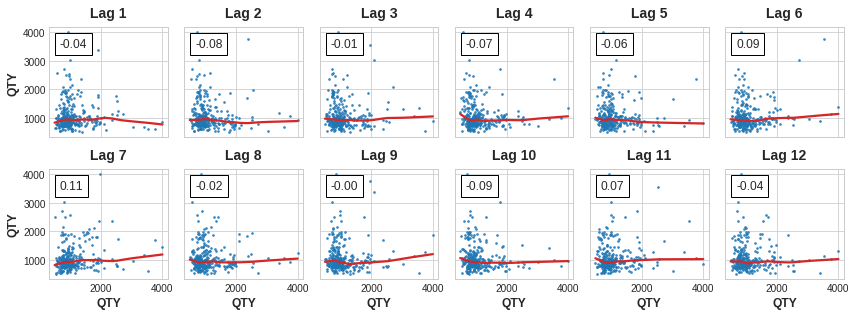

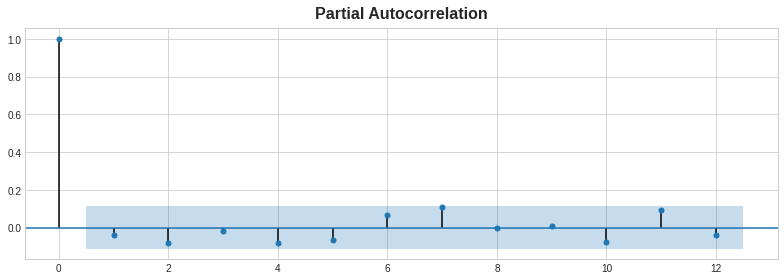

In [ ]:
_ = plot_lags(daily_sales.QTY, lags=12, nrows=2) #for weekly, they took 12.
_ = plot_pacf(daily_sales.QTY, lags=12)

**Hybrid Forecasting with Residuals**

In previous lessons, we used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:

In [ ]:
"""
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
"""

'\n# 1. Train and predict with first model\nmodel_1.fit(X_train_1, y_train)\ny_pred_1 = model_1.predict(X_train)\n\n# 2. Train and predict with second model on residuals\nmodel_2.fit(X_train_2, y_train - y_pred_1)\ny_pred_2 = model_2.predict(X_train_2)\n\n# 3. Add to get overall predictions\ny_pred = y_pred_1 + y_pred_2\n'

We'll usually want to use different feature sets (X_train_1 and X_train_2 above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

Designing Hybrids:


There are many ways you could combine machine learning models besides the way we've outlined in this lesson. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.

There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these boosted hybrids; the method of using predictions as features is known as "stacking", so we will call these stacked hybrids.

EX:

The US Retail Sales dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

First let's use a linear regression model to learn the trend in each series. For demonstration, we'll use a quadratic (order 2) trend. (The code here is basically the same as that in previous lessons.) Though the fit isn't perfect, it will be enough for our needs.

(212, 2)
X_train.shape             const  trend
Date                    
2022-01-01    1.0    1.0
2022-01-02    1.0    2.0
2022-01-03    1.0    3.0
2022-01-04    1.0    4.0
2022-01-05    1.0    5.0
...           ...    ...
2022-08-13    1.0  208.0
2022-08-14    1.0  209.0
2022-08-15    1.0  210.0
2022-08-16    1.0  211.0
2022-08-17    1.0  212.0

[212 rows x 2 columns]
(212, 1)
X_train.shape              QTY
Date            
2022-01-01   710
2022-01-02   782
2022-01-03   956
2022-01-04  2530
2022-01-05  1590
...          ...
2022-08-13  1000
2022-08-14  1021
2022-08-15  1212
2022-08-16   937
2022-08-17   861

[212 rows x 1 columns]
(90, 2)
X_test.shape              QTY
Date            
2022-01-01   710
2022-01-02   782
2022-01-03   956
2022-01-04  2530
2022-01-05  1590
...          ...
2022-08-13  1000
2022-08-14  1021
2022-08-15  1212
2022-08-16   937
2022-08-17   861

[212 rows x 1 columns]
(90, 1)
y_test.shape              QTY
Date            
2022-01-01   710
2022-01-02   782
2022-

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


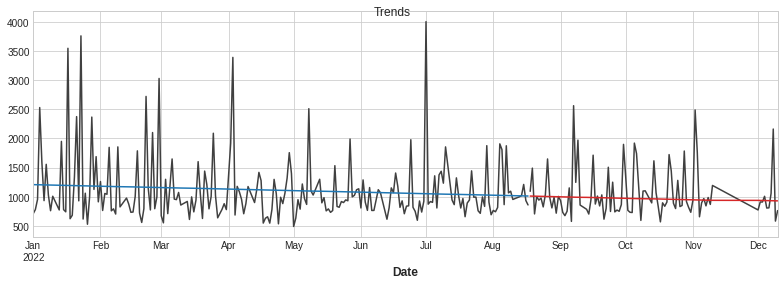

In [ ]:
y = daily_sales.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # linear trend?
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the last 90 days. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=30 * 3, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

print(X_train.shape)
print("X_train.shape", X_train)
print(y_train.shape)
print("X_train.shape", y_train)
print(X_test.shape)
print("X_test.shape", y_train)
print(y_test.shape)
print("y_test.shape", y_train)

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from wide format, with one time series per column, to long format, with series indexed by categories along rows.
BUT WE DO NOT NEED THIS

In [ ]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
#X = daily_sales.stack() # pivot dataset wide to long
X = daily_sales.copy()
#X = X.squeeze()
display(X.head())
#y = X.pop('Sales')  # grab target series
y= X.copy()

,QTY
Date,
2022-01-01,710
2022-01-02,782
2022-01-03,956
2022-01-04,2530
2022-01-05,1590


In [ ]:
#X.name = "Sales"
type(X)

pandas.core.frame.DataFrame

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for 'Industries' into a categorical feature with a label encoding. 
NOT NEEDED.

We'll also create a feature for MONTHLY OR ANNUAL seasonality by pulling the month numbers out of the time index.

In [ ]:
'''
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
'''
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

(212, 2)
(212, 1)
(90, 2)
(90, 1)
             QTY  Month
Date                   
2022-01-01   710      1
2022-01-02   782      1
2022-01-03   956      1
2022-01-04  2530      1
2022-01-05  1590      1
...          ...    ...
2022-08-13  1000      8
2022-08-14  1021      8
2022-08-15  1212      8
2022-08-16   937      8
2022-08-17   861      8

[212 rows x 2 columns]
             QTY
Date            
2022-01-01   710
2022-01-02   782
2022-01-03   956
2022-01-04  2530
2022-01-05  1590
...          ...
2022-08-13  1000
2022-08-14  1021
2022-08-15  1212
2022-08-16   937
2022-08-17   861

[212 rows x 1 columns]
             QTY  Month
Date                   
2022-08-18  1094      8
2022-08-19  1492      8
2022-08-20   707      8
2022-08-21  1000      8
2022-08-22   944      8
...          ...    ...
2022-12-06   811     12
2022-12-07  1059     12
2022-12-08  2162     12
2022-12-09   584     12
2022-12-10   764     12

[90 rows x 2 columns]
             QTY
Date            
2022-08-18  1094

Now we'll convert the trend predictions made earlier to long format(NOT NEEDED) and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn

In [ ]:
'''
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

'''
y_fit = y_fit.copy() # trend from training set
y_pred = y_pred.copy() # trend from test set

# Create residuals (the collection of detrended series) from the training set
print(y_fit)
print(y_train)
y_resid = y_train - y_fit

#X_train = X_train.reshape(212,1)
#y_resid = y_resid.reshape(780,1)
# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train)
y_fit_boosted = y_fit_boosted.reshape(212,1)
y_fit_boosted = y_fit_boosted + y_fit
#y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test)
y_pred_boosted = y_pred_boosted.reshape(90,1)
y_pred_boosted = y_pred_boosted + y_pred
#y_pred_boosted = xgb.predict(X_test) + y_pred

                    QTY
Date                   
2022-01-01  1208.893303
2022-01-02  1207.968981
2022-01-03  1207.044660
2022-01-04  1206.120338
2022-01-05  1205.196016
...                 ...
2022-08-13  1017.558701
2022-08-14  1016.634379
2022-08-15  1015.710057
2022-08-16  1014.785736
2022-08-17  1013.861414

[212 rows x 1 columns]
             QTY
Date            
2022-01-01   710
2022-01-02   782
2022-01-03   956
2022-01-04  2530
2022-01-05  1590
...          ...
2022-08-13  1000
2022-08-14  1021
2022-08-15  1212
2022-08-16   937
2022-08-17   861

[212 rows x 1 columns]
[09:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


The fit appears quite good, though we can see how the trend learned by XGBoost is only as good as the trend learned by the linear regression -- in particular, XGBoost wasn't able to compensate for the poorly fit trend in the 'BuildingMaterials' series.

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


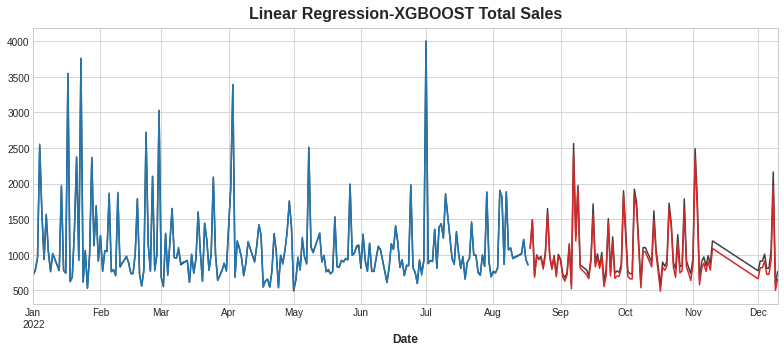

In [ ]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['Linear Regression-XGBOOST Total Sales'],
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

The time between the origin and the horizon is the lead time (or sometimes latency) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

Above we can see a small gap before forcasted line started

In [ ]:
#y_pred_boosted
lr_xg_mse = np.sqrt(mean_squared_error(y_pred_boosted, daily_sales['QTY'][-90:]))
lr_xg_mae = mean_absolute_error(y_pred_boosted, daily_sales['QTY'][-90:])
pred_boosted_r2 = r2_score(y_pred_boosted['QTY'], daily_sales['QTY'][-90:])
lrxg_mean_absolute_percentage_error = mean_absolute_percentage_error(y_pred_boosted, daily_sales['QTY'][-90:])
print('Linear-xgboost RMSE: ', lr_xg_mse)
print('Linear-xgboost MAE: ', lr_xg_mae)
print('Linear-xgboost R2 Score: ', pred_boosted_r2)
print('Linear-xgboost mape: ', lrxg_mean_absolute_percentage_error)

Linear-xgboost RMSE:  77.48141879399738
Linear-xgboost MAE:  68.94700358320986
Linear-xgboost R2 Score:  0.9636206592736255
Linear-xgboost mape:  0.07743904242822666


In [ ]:
pred_boosted_r2

0.9636206592736255

**Multioutput model**

Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance

**Direct strategy**

Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

**Recursive strategy**

Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

**DirRec strategy**


A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

Let's use multi output and direct strategy and use lags for another forcasting

In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

First we'll prepare our target series (daily sales) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [ ]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    

# 6 days of lag features
y = daily_sales.QTY.copy()
X = make_lags(y, lags=45).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
    
# 90 day forecast
y = make_multistep_target(y, steps=90).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

**Multioutput model**

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [ ]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=90, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 212 days in the training set and 90 days in the test set, and we now have an 90-step forecast for each of these weeks.

Train RMSE: 412.10
Test RMSE: 477.12
0.35117371202620085
-0.2176040947358763
343.52370445867115


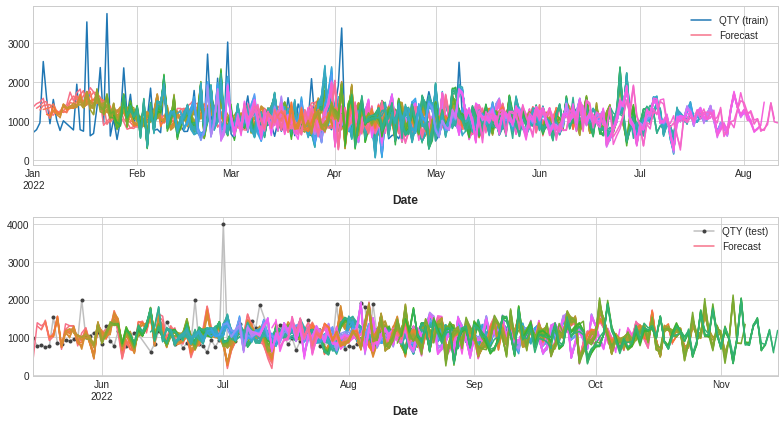

In [ ]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
pred_lin_r2x = r2_score(y_train,y_fit)
pred_lin_r2 = r2_score(y_test,y_pred)
print(pred_lin_r2x)
print(pred_lin_r2)
rf_mae = mean_absolute_error(y_test, y_pred)
print(rf_mae)
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = daily_sales.QTY[y_fit.index].plot(ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['QTY (train)', 'Forecast'])
ax2 = daily_sales.QTY[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['QTY (test)', 'Forecast'])

**Direct strategy**

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's MultiOutputRegressor

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Train RMSE: 75.58
Test RMSE: 455.55
0.35117371202620085
-0.2176040947358763


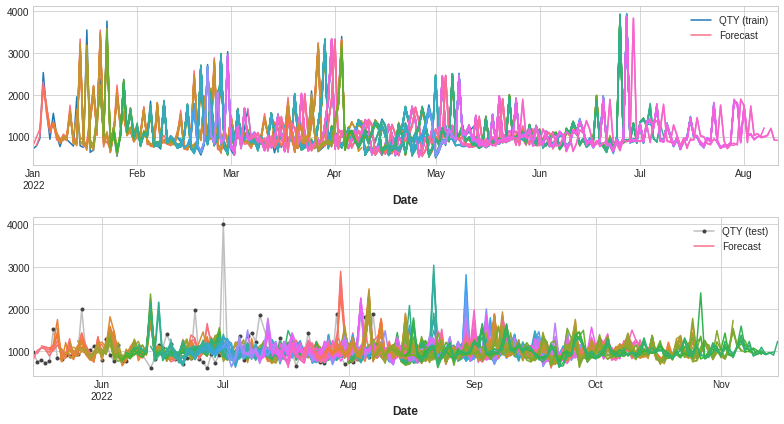

In [ ]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

pred_dir_xg_r2x = r2_score(y_train,y_fit)
pred_dir_xg_r2 = r2_score(y_test,y_pred)
print(pred_lin_r2x)
print(pred_lin_r2)
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = daily_sales.QTY[y_fit.index].plot(ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['QTY (train)', 'Forecast'])
ax2 = daily_sales.QTY[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['QTY (test)', 'Forecast'])

XGBoost here is doing some overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the daily sale better than the linear regression model. It would likely do even better with some hyperparameter tuning.

**To use the DirRec strategy**, you would only need to replace MultiOutputRegressor with another scikit-learn wrapper, RegressorChain. The Recursive strategy we would need to code ourselves.

In [ ]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Train RMSE: 264.54
Test RMSE: 459.75
0.35117371202620085
-0.2176040947358763
294.1669098277151


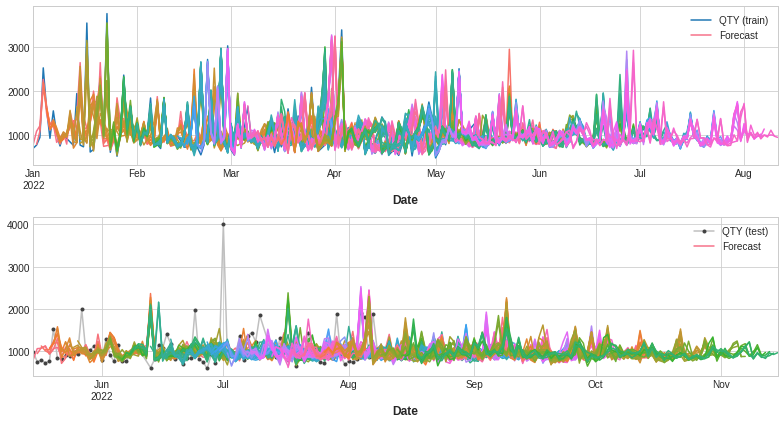

In [ ]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
pred_direc_xg_r2x = r2_score(y_train,y_fit)
pred_direc_xg_r2 = r2_score(y_test,y_pred)
print(pred_lin_r2x)
print(pred_lin_r2)
rf_mae = mean_absolute_error(y_test, y_pred)
print(rf_mae)
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = daily_sales.QTY[y_fit.index].plot(ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['QTY (train)', 'Forecast'])
ax2 = daily_sales.QTY[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['QTY (test)', 'Forecast'])

In [ ]:
#y_pred
#DirRec_xgb_r2 = r2_score(y_pred[:,-7], daily_sales['QTY'][-74:])
#pred_boosted_r2
y_pred['average_fore'] = y_pred.mean(axis=1)
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,...,y_step_82,y_step_83,y_step_84,y_step_85,y_step_86,y_step_87,y_step_88,y_step_89,y_step_90,average_fore
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-15,805.174988,1066.402100,1076.318726,1133.700806,951.858948,1069.132690,1095.332153,873.451294,1102.306274,961.060974,...,908.421814,914.506897,1063.484741,880.461426,942.288513,1069.185913,1037.557983,1403.472778,892.115540,1009.409488
2022-05-16,949.724731,1088.737305,1117.516602,933.806274,1046.393433,1311.816650,718.482361,840.360840,1160.036499,1032.834229,...,914.826355,975.800171,824.994934,1000.214844,1006.558655,908.152588,1299.093384,885.015198,1016.747437,1012.796757
2022-05-17,1129.171021,1014.971313,963.037415,1191.395020,1208.266724,878.557739,864.926636,1036.388916,930.032837,1006.040283,...,960.000244,860.156128,906.073975,954.175171,835.222412,1155.439697,872.650269,928.283875,959.751831,994.662796
2022-05-18,1040.088501,1041.591064,1235.307617,1424.370972,1025.026245,955.372131,907.392639,950.157288,1038.121460,954.515808,...,901.196594,1041.537598,937.708008,859.044373,1138.808838,877.378235,969.324585,921.976624,941.477722,997.637734
2022-05-19,1074.599121,1190.454834,1412.255981,1102.474365,970.909302,1067.273560,788.666626,1103.250732,1081.799438,895.191772,...,950.492004,968.732666,922.733398,1096.820801,901.615662,990.452209,942.900391,875.127380,947.580200,993.923030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-14,895.240845,919.648926,1031.070190,1579.691650,883.921204,851.535095,947.792236,870.022095,1104.280273,871.590332,...,836.283264,886.887939,977.138428,1076.407349,1001.889526,895.917725,976.890564,1159.174072,913.153564,970.903305
2022-08-15,882.766724,933.799255,1572.446777,852.225769,809.184204,912.336853,1031.390015,1108.227051,661.512451,870.613464,...,880.299866,983.437378,1119.165649,1105.575806,889.308899,923.598328,1094.652832,895.689087,976.379639,981.774193
2022-08-16,927.215637,1765.336426,942.477356,715.915894,887.375427,965.546570,1055.031250,798.146240,916.352966,959.282593,...,944.611572,979.275879,1132.851318,1218.870972,831.881042,963.761353,908.414490,912.877258,997.396790,982.733097


Linear-Random Forest

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


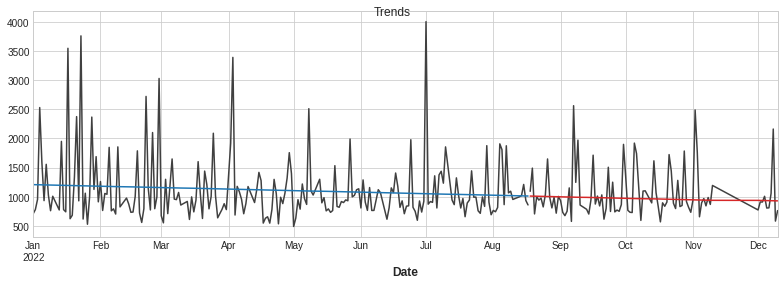

In [ ]:
y = daily_sales.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # linear trend?
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the last 90 days. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=30 * 3, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [ ]:
X = daily_sales.copy()
y= X.copy()  # grab target series

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [ ]:
'''
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

'''
y_fit = y_fit.copy() # trend from training set
y_pred = y_pred.copy() # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

#X_train = X_train.reshape(212,1)
#y_resid = y_resid.reshape(780,1)
# Train XGBoost on the residuals
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = rf_model.predict(X_train)
y_fit_boosted = y_fit_boosted.reshape(212,1)
y_fit_boosted = y_fit_boosted + y_fit
#y_fit_boosted = rf_model.predict(X_train) + y_fit
y_pred_boosted = rf_model.predict(X_test)
y_pred_boosted = y_pred_boosted.reshape(90,1)
y_pred_boosted = y_pred_boosted + y_pred
#y_pred_boosted = rf_model.predict(X_test) + y_pred

<ipython-input-108-9d1bb1097e08>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_resid)


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


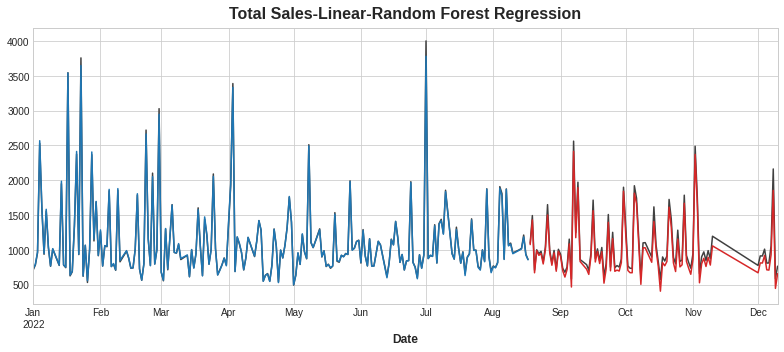

In [ ]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['Total Sales-Linear-Random Forest Regression'],
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [ ]:
lin_rf_rmse = np.sqrt(mean_squared_error(y_pred_boosted, daily_sales['QTY'][-90:]))
lin_rf_mae = mean_absolute_error(y_pred_boosted, daily_sales['QTY'][-90:])
lin_rf_r2 = r2_score(y_pred_boosted, daily_sales['QTY'][-90:])
lrrf_mean_absolute_percentage_error = mean_absolute_percentage_error(y_pred_boosted, daily_sales['QTY'][-90:])
print('Linear-Random Forest RMSE: ', lin_rf_rmse)
print('Linear-Random Forest MAE: ', lin_rf_mae)
print('Linear-Random Forest R2 Score: ', lin_rf_r2)
print('Linear-Random Forest mape: ', lrrf_mean_absolute_percentage_error)

Linear-Random Forest RMSE:  93.17920264651733
Linear-Random Forest MAE:  82.25835085319892
Linear-Random Forest R2 Score:  0.9459694023309059
Linear-Random Forest mape:  0.09434206545044677


**Linear Regression only**

In [ ]:
daily_sales = store_sales.groupby('Date')['QTY'].sum().reset_index()
daily_sales['Date'] = daily_sales['Date'].dt.to_timestamp()
supervised_data=daily_sales.drop(['Date'],axis=1)

supervised_data['lagged_QTY'] = supervised_data['QTY'].shift()
supervised_data = supervised_data.dropna().reset_index(drop=True)
print(supervised_data)
''''
for i in range(1,90): #Can not give 1,12 cause it would result in at least one nan value in every column. Thus iterating only 6 times
    col_name = 'Day' + str(i)
    supervised_data[col_name] = supervised_data['QTY'].shift(i) #shift(i) means shifting the iterator for desired no. of periods
    #print(supervised_data) #Run this for any confusion
supervised_data = supervised_data.dropna().reset_index(drop=True) #dropping rows with nan values
supervised_data
#For any time series, preprocess data in such a way that we can create ind. and dep. features based on no. of time steps
'''
train_data = supervised_data[:-90] #Training first 3 rows, doing this with 4 eows give better features lmao
test_data = supervised_data[-90:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)


x_train = train_data["lagged_QTY"].to_frame()
y_train = train_data["QTY"]
x_test = test_data["lagged_QTY"].to_frame()
y_test = test_data["QTY"]
print(x_train.head())

#train_data = daily_sales[:-90]
#test_data= daily_sales[-90:]  # grab target series
'''
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

linearreg_model=LinearRegression()
linearreg_model.fit(X_train,y_train)
linearreg_prediction=linearreg_model.predict(y_test)
lr_mse = np.sqrt(mean_squared_error(linearreg_prediction, daily_sales['QTY'][-90:]))
lr_mae = mean_absolute_error(linearreg_prediction, daily_sales['QTY'][-90:])
lr_r2 = r2_score(linearreg_prediction, daily_sales['QTY'][-90:])
print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2 Score: ', lr_r2)
'''
#print('Train Data Shape:', train_data.shape)
#print('Test Data Shape:', test_data.shape)

      QTY  lagged_QTY
0     782       710.0
1     956       782.0
2    2530       956.0
3    1590      2530.0
4     935      1590.0
..    ...         ...
296   811       808.0
297  1059       811.0
298  2162      1059.0
299   584      2162.0
300   764       584.0

[301 rows x 2 columns]
Train Data Shape: (211, 2)
Test Data Shape: (90, 2)
   lagged_QTY
0       710.0
1       782.0
2       956.0
3      2530.0
4      1590.0


"\n# Create splits\nX_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]\ny_train, y_test = y.loc[idx_train], y.loc[idx_test]\n\nlinearreg_model=LinearRegression()\nlinearreg_model.fit(X_train,y_train)\nlinearreg_prediction=linearreg_model.predict(y_test)\nlr_mse = np.sqrt(mean_squared_error(linearreg_prediction, daily_sales['QTY'][-90:]))\nlr_mae = mean_absolute_error(linearreg_prediction, daily_sales['QTY'][-90:])\nlr_r2 = r2_score(linearreg_prediction, daily_sales['QTY'][-90:])\nprint('Linear Regression MSE: ', lr_mse)\nprint('Linear Regression MAE: ', lr_mae)\nprint('Linear Regression R2 Score: ', lr_r2)\n"

In [ ]:
#store_sales['Date'] = store_sales['Date'].dt.to_period('M')

sales_dates = daily_sales['Date'][-90:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

#daily_sales = store_sales.groupby('Date')['QTY'].sum().reset_index()
#daily_sales['Date'] = daily_sales['Date'].dt.to_timestamp()
#sales_dates=daily_sales['Date'][-90:].reset_index(drop=True)
#predict_df = pd.DataFrame(sales_dates)
#print(actual_sales)
actual_sales=daily_sales['QTY'][-90:].to_list()
#print(actual_sales)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fa7a21700>,
      dtype=object)

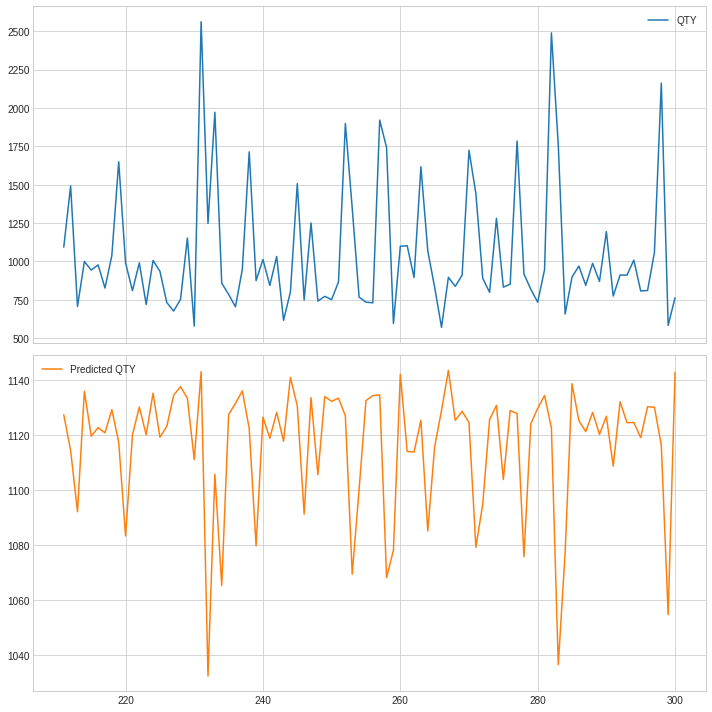

In [ ]:
linearreg_model=LinearRegression()
#linearreg_model.fit(X_train,y_train)
linearreg_model.fit(x_train, y_train)
#linearreg_prediction=linearreg_model.predict(X_test)
predictions = linearreg_model.predict(x_test)
results = y_test.to_frame()
results["Predicted QTY"] = predictions
results.head(2)
# Plot the first 20 predictions vs the true values
results[:90].plot(subplots=True, figsize = (10, 10))

In [ ]:
'''
linearreg_prediction=linearreg_prediction.reshape(-1,1)
lr_pre_test_set=np.concatenate([linearreg_prediction,X_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set) #Transforming predicted values to original self
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + actual_sales[index])
lr_pre_series = pd.Series(result_list,name='linear prediction')
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)
'''
lr_mse = np.sqrt(mean_squared_error(results['QTY'], results['Predicted QTY']))
lr_mae = mean_absolute_error(results['Predicted QTY'], daily_sales['QTY'][-90:])
lr_r2 = r2_score(results['Predicted QTY'], daily_sales['QTY'][-90:])
print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2 Score: ', lr_r2)

Linear Regression MSE:  424.04738971027314
Linear Regression MAE:  341.1209660052396
Linear Regression R2 Score:  -330.1291915770604


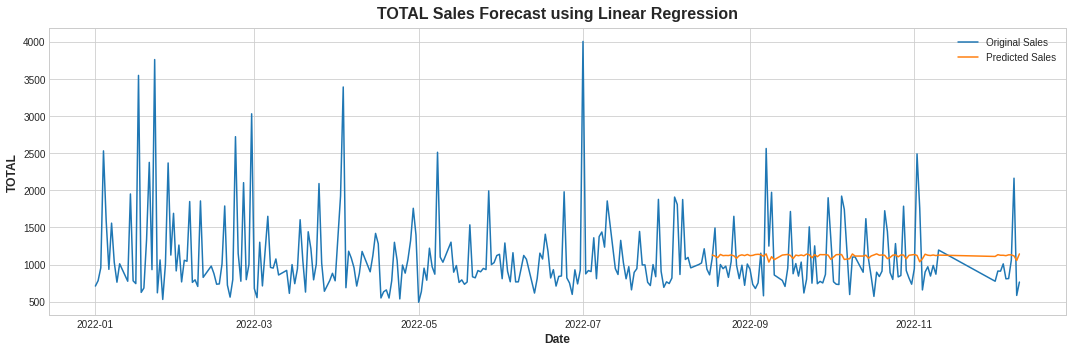

In [ ]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(daily_sales['Date'], daily_sales['QTY'])
#Predicted sales
plt.plot(predict_df['Date'], results['Predicted QTY'])
plt.title("TOTAL Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("TOTAL")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

**Random Forest Only**

Random Forest RMSE:  424.04738971027314
Random Forest MAE:  341.1209660052396
Random Forest R2 Score:  -330.1291915770604


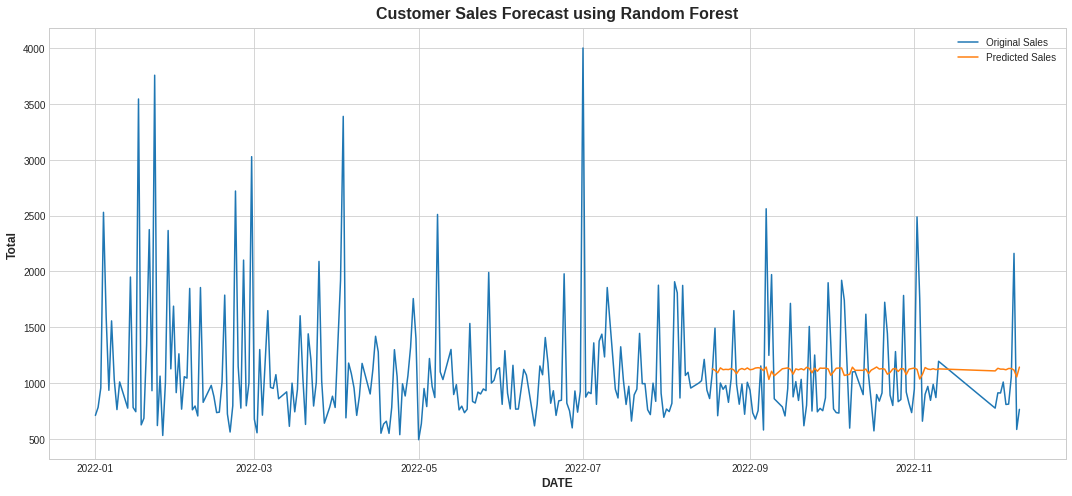

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
'''
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + actual_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)
'''
rf_rmse = np.sqrt(mean_squared_error(results['Predicted QTY'], daily_sales['QTY'][-90:]))
rf_mae = mean_absolute_error(results['Predicted QTY'], daily_sales['QTY'][-90:])
rf_r2 = r2_score(results['Predicted QTY'], daily_sales['QTY'][-90:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)
plt.figure(figsize=(15,7))
plt.plot(daily_sales['Date'], daily_sales['QTY'])
plt.plot(predict_df['Date'], results['Predicted QTY'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("DATE")
plt.ylabel("Total")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

**XGBoost Only**

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + actual_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], daily_sales['QTY'][-90:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], daily_sales['QTY'][-90:])
xgb_r2 = r2_score(predict_df['xgb_pred'], daily_sales['QTY'][-90:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)
plt.figure(figsize=(15,7))
plt.plot(daily_sales['Date'], daily_sales['QTY'])
plt.plot(predict_df['Date'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("TOTAL")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

XGBoostError: ignored